<a href="https://colab.research.google.com/github/18bce133/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/training.1600000.processed.noemoticon.csv.zip" "training.1600000.processed.noemoticon.csv.zip"
!unzip "training.1600000.processed.noemoticon.csv.zip"
!rm "training.1600000.processed.noemoticon.csv.zip"
!mv "training.1600000.processed.noemoticon.csv" "train.csv"

Archive:  training.1600000.processed.noemoticon.csv.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import pickle
from time import time
import warnings
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
nltk.download('stopwords') 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train  = pd.read_csv('train.csv',encoding='ISO-8859-1')

In [ ]:
train.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
train.columns = ['target','id','date','flag','user','text']
train.target = train.target.map({4:1,0:0})

In [ ]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [ ]:
# remove twitter handles (@user)
train['text'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")

In [ ]:
train['text'] = train['text'].str.replace("[^a-zA-Z#]", " ")
stopwords = nltk.corpus.stopwords.words('english')
train['text'] = train['text'].apply(lambda x: [item for item in x.lower().strip().split(" ") if item not in stopwords and item != ""])
train['text'] = train['text'].apply(lambda x : ' '.join(map(str,x)))

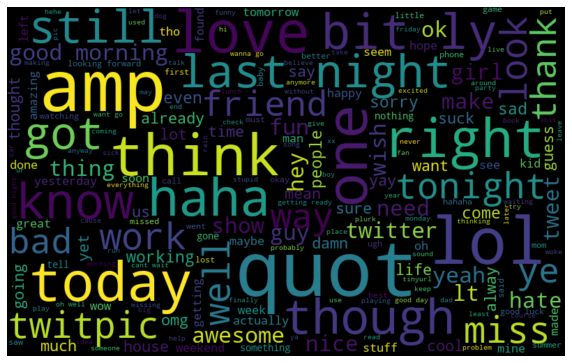

In [ ]:
all_words = ' '.join([text for text in train['text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


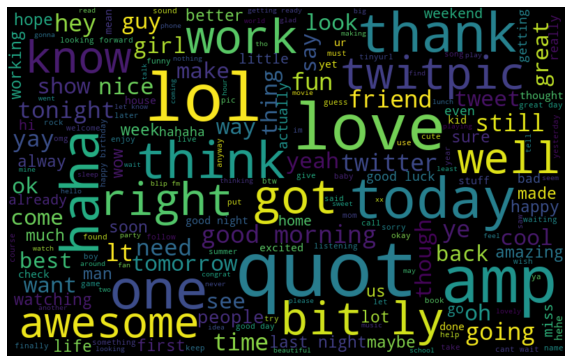

In [ ]:
normal_words =' '.join([text for text in train['text'][train['target'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

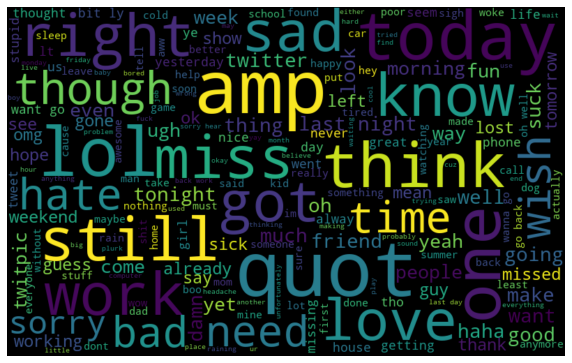

In [ ]:
normal_words =' '.join([text for text in train['text'][train['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
train['text'].head()

0    upset update facebook texting might cry result...
1    dived many times ball managed save rest go bounds
2                     whole body feels itchy like fire
3                                     behaving mad see
4                                           whole crew
Name: text, dtype: object

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

train['text'] = train['text'].apply(lambda x: [stemmer.stem(i) for i in x.split(" ")]) # stemming
train['text'] = train['text'].apply(lambda x : ' '.join(map(str,x)))
train['text'].head()

0    upset updat facebook text might cri result sch...
1         dive mani time ball manag save rest go bound
2                      whole bodi feel itchi like fire
3                                        behav mad see
4                                           whole crew
Name: text, dtype: object

In [ ]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [ ]:
train.head
HT_regular = hashtag_extract(train['text'][train['target'] == 1])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['text'][train['target'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

<bound method NDFrame.head of               Hashtag  Count
83       followfriday   2521
217                ff    884
61                 fb    727
5167              seb    428
5         musicmonday    389
1272       squarespac    283
4376  mcflyforgermani    219
2994           myweak    218
3104        marsiscom    205
181              asot    202>


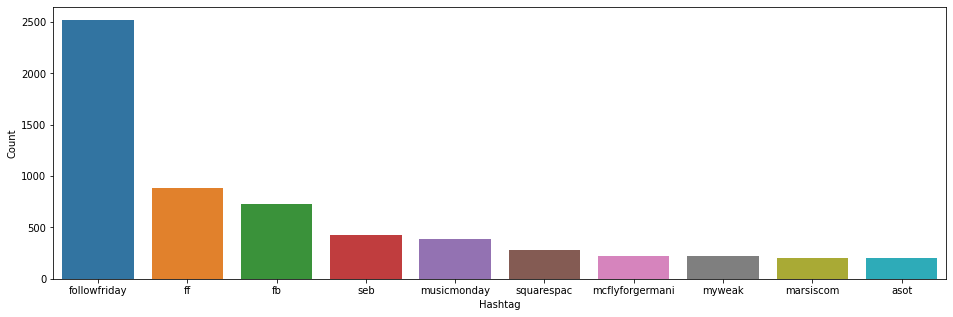

In [ ]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
print(d.head)
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

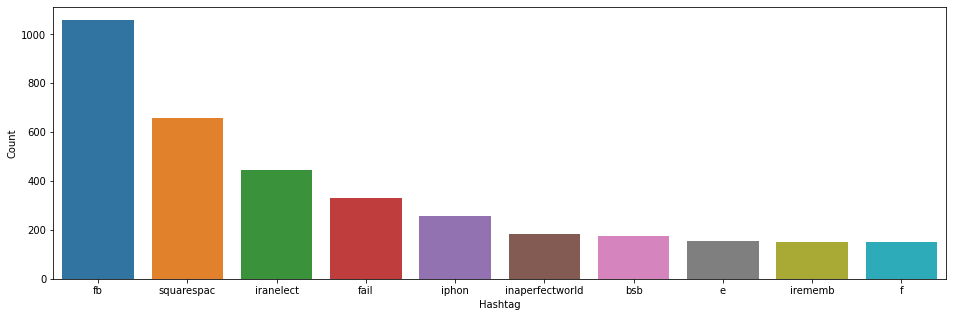

In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [ ]:
# splitting data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], random_state=42, test_size=0.3)

In [ ]:
print("Number of sentences in train set :-",X_train.shape[0])
print("Number of sentences in test set :-",X_test.shape[0])

Number of sentences in train set :- 1119999
Number of sentences in test set :- 480000


In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.75,min_df=2,max_features=200)),
    ('scaler',MaxAbsScaler()),
    ('clf', LogisticRegression(max_iter=100,penalty='l2')),
])

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=200,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('scaler', MaxAbsScaler(copy=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                          

In [ ]:
with open("model.pkl",'wb') as md:
  pickle.dump(pipeline,md)
prediction = pipeline.predict(X_test) # predicting on the validation set

f1_score(y_test, prediction) # calculating f1 score

0.7098866303789828